In [1]:
# 1. Importul Bibliotecilor Necesare
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import mediapipe as mp
from math import hypot, degrees, atan2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 2. Definirea Căilor și Etichetelor
data_dir = 'data'  # Asigură-te că această cale este corectă
emotion_labels = {
    'anger': 0,
    'contempt': 1,
    'disgust': 2,
    'fear': 3,
    'happy': 4,
    'neutral': 5,
    'sad': 6,
    'surprise': 7
}

In [3]:
# 3. Extragerea Landmark-urilor și Calcularea Caracteristicilor Geometrice
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, 
                                  max_num_faces=1, 
                                  refine_landmarks=True, 
                                  min_detection_confidence=0.5)

def extract_landmarks(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)
    
    if not results.multi_face_landmarks:
        return None
    
    face_landmarks = results.multi_face_landmarks[0]
    landmarks = []
    for lm in face_landmarks.landmark:
        x = int(lm.x * image.shape[1])
        y = int(lm.y * image.shape[0])
        landmarks.append((x, y))
    
    return landmarks

def calculate_features(landmarks):
    features = []
    
    # Distanța dintre ochi
    left_eye_distance = hypot(landmarks[33][0] - landmarks[263][0], landmarks[33][1] - landmarks[263][1])
    right_eye_distance = hypot(landmarks[133][0] - landmarks[362][0], landmarks[133][1] - landmarks[362][1])
    features.append(left_eye_distance)
    features.append(right_eye_distance)
    
    # Distanța dintre colțurile gurii
    mouth_width = hypot(landmarks[61][0] - landmarks[291][0], landmarks[61][1] - landmarks[291][1])
    features.append(mouth_width)
    
    # Întinderea sprâncenelor
    left_brow_length = hypot(landmarks[55][0] - landmarks[285][0], landmarks[55][1] - landmarks[285][1])
    right_brow_length = hypot(landmarks[105][0] - landmarks[334][0], landmarks[105][1] - landmarks[334][1])
    features.append(left_brow_length)
    features.append(right_brow_length)
    
    # Unghiul dintre nas și gură
    angle = calculate_angle(landmarks[1], landmarks[61], landmarks[291])
    features.append(angle)
    
    return features

def calculate_angle(a, b, c):
    ang = degrees(atan2(c[1]-b[1], c[0]-b[0]) - atan2(a[1]-b[1], a[0]-b[0]))
    ang = abs(ang)
    if ang > 180:
        ang = 360 - ang
    return ang

In [4]:
# 4. Adăugarea Ocluziunilor Artificiale
def add_occlusion(image):
    """Adaugă ocluziuni artificiale (măști sau ochelari) pe imagine."""
    img = image.copy()
    h, w, _ = img.shape
    occlusion_type = random.choice(['mask', 'glasses', 'random'])
    
    if occlusion_type == 'mask':
        mask_width = random.randint(int(w*0.3), int(w*0.6))
        mask_height = random.randint(int(h*0.1), int(h*0.3))
        x_start = random.randint(0, w - mask_width)
        y_start = random.randint(int(h*0.4), int(h*0.6))
        cv2.rectangle(img, (x_start, y_start), (x_start + mask_width, y_start + mask_height), (0, 0, 0), -1)
    elif occlusion_type == 'glasses':
        glasses_width = random.randint(int(w*0.3), int(w*0.5))
        glasses_height = random.randint(int(h*0.05), int(h*0.1))
        x_start = random.randint(0, w - glasses_width)
        y_start = random.randint(int(h*0.3), int(h*0.45))
        cv2.rectangle(img, (x_start, y_start), (x_start + glasses_width, y_start + glasses_height), (0, 0, 0), -1)
    elif occlusion_type == 'random':
        # Adaugă o formă aleatorie de ocluziune
        num_shapes = random.randint(1, 3)
        for _ in range(num_shapes):
            shape_type = random.choice(['rectangle', 'circle'])
            if shape_type == 'rectangle':
                rect_width = random.randint(int(w*0.1), int(w*0.3))
                rect_height = random.randint(int(h*0.1), int(h*0.3))
                x_start = random.randint(0, w - rect_width)
                y_start = random.randint(0, h - rect_height)
                cv2.rectangle(img, (x_start, y_start), (x_start + rect_width, y_start + rect_height), (0, 0, 0), -1)
            elif shape_type == 'circle':
                radius = random.randint(int(min(w, h)*0.05), int(min(w, h)*0.15))
                center_x = random.randint(radius, w - radius)
                center_y = random.randint(radius, h - radius)
                cv2.circle(img, (center_x, center_y), radius, (0, 0, 0), -1)
    return img


In [6]:
import random

# 5. Încărcarea și Preprocesarea Imaginilor
X = []
y = []
geom_features = []
original_images = []
preprocessed_images = []

for emotion, label in emotion_labels.items():
    folder_path = os.path.join(data_dir, emotion)
    
    if os.path.exists(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            
            # Stocăm imaginea originală pentru ploturi
            original_images.append(img.copy())
            
            # Adăugăm ocluziuni artificiale
            img_occluded = add_occlusion(img)
            preprocessed_images.append(img_occluded.copy())
            
            # Preprocesăm imaginea
            img_gray = cv2.cvtColor(img_occluded, cv2.COLOR_BGR2GRAY)
            img_resized = cv2.resize(img_gray, (48, 48))
            img_normalized = img_resized / 255.0
            img_final = np.expand_dims(img_normalized, axis=-1)  # (48, 48, 1)
            
            # Extrage landmark-urile
            landmarks = extract_landmarks(img_occluded)
            if landmarks is None:
                continue  # Sărim peste imagini fără față detectată
            
            # Calculează caracteristicile geometrice
            features = calculate_features(landmarks)
            
            # Adaugă datele
            X.append(img_final)
            y.append(label)
            geom_features.append(features)

# Convertim listele în array-uri numpy
X = np.array(X, dtype='float32')  # (n_samples, 48, 48, 1)
y = np.array(y)
geom_features = np.array(geom_features, dtype='float32')  # (n_samples, num_features)

print(f"Forma imaginilor: {X.shape}")
print(f"Forma label-urilor: {y.shape}")
print(f"Forma caracteristicilor geometrice: {geom_features.shape}")


Forma imaginilor: (28792, 48, 48, 1)
Forma label-urilor: (28792,)
Forma caracteristicilor geometrice: (28792, 6)


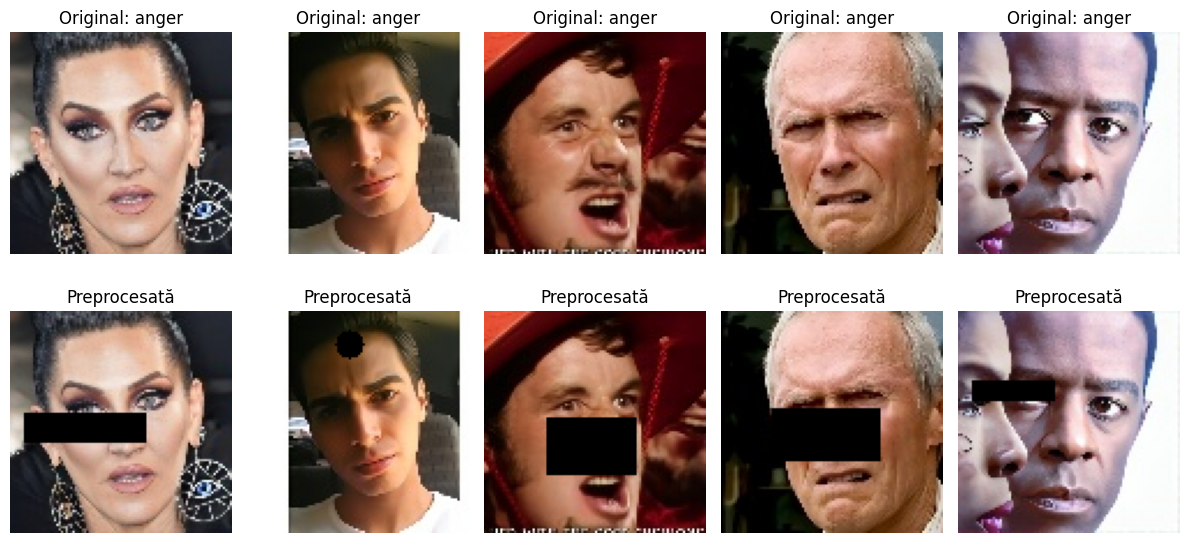

In [7]:
# 6. Vizualizarea Imaginilor Originale și Preprocesate
num_samples = 5
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    # Imaginea originală (BGR la RGB)
    img_original = cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB)
    plt.subplot(2, num_samples, i+1)
    plt.imshow(img_original)
    plt.title(f"Original: {list(emotion_labels.keys())[y[i]]}")
    plt.axis('off')
    
    # Imaginea preprocesată (cu ocluziuni)
    img_processed = cv2.cvtColor(preprocessed_images[i], cv2.COLOR_BGR2RGB)
    plt.subplot(2, num_samples, num_samples + i +1)
    plt.imshow(img_processed)
    plt.title("Preprocesată")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# 1. One-Hot Encoding pentru label-uri
y_onehot = to_categorical(y, num_classes=len(emotion_labels))

# 2. Împărțirea Datelor în Seturi de Antrenare, Validare și Test
X_train, X_temp, y_train, y_temp, geom_train, geom_temp = train_test_split(
    X, y_onehot, geom_features, test_size=0.3, random_state=42, stratify=y_onehot
)
X_val, X_test, y_val, y_test, geom_val, geom_test = train_test_split(
    X_temp, y_temp, geom_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Train geom shape: {geom_train.shape}, Validation geom shape: {geom_val.shape}, Test geom shape: {geom_test.shape}")



Train shape: (20154, 48, 48, 1), Validation shape: (4319, 48, 48, 1), Test shape: (4319, 48, 48, 1)
Train geom shape: (20154, 6), Validation geom shape: (4319, 6), Test geom shape: (4319, 6)


In [9]:
# 3. Normalizarea Caracteristicilor Geometrice
scaler = StandardScaler()
geom_train = scaler.fit_transform(geom_train)
geom_val = scaler.transform(geom_val)
geom_test = scaler.transform(geom_test)

In [10]:
# 4. Definirea Modelului Hibrid
# Ramura CNN pentru imagini
input_img = Input(shape=(48, 48, 1), name='image_input')

x = Conv2D(32, (3,3), padding='same')(input_img)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Ramura Geometrică pentru caracteristici
input_geom = Input(shape=(geom_features.shape[1],), name='geom_input')

y = Dense(64, activation='relu')(input_geom)
y = Dropout(0.5)(y)
y = Dense(64, activation='relu')(y)
y = Dropout(0.5)(y)

# Combinarea ramurilor
combined = concatenate([x, y])

# Strat final de clasificare
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(len(emotion_labels), activation='softmax')(z)

# Definirea modelului complet
model = Model(inputs=[input_img, input_geom], outputs=z)

# Compilarea modelului
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 12, 12,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ geom_input          │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 128) │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        448 │ geom_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    589,952 │ flatten[0][0]   

 Total params: 713,864 (2.72 MB)

 Trainable params: 713,416 (2.72 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate

# Definirea intrării pentru imagini
image_input = Input(shape=(48, 48, 1), name='image_input')

# Strat convoluțional 1
x = Conv2D(16, (3, 3), activation='relu', padding='same')(image_input)
x = MaxPooling2D((2, 2))(x)

# Strat convoluțional 2
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Aplatizare
x = Flatten()(x)

# Definirea intrării pentru caracteristicile geometrice
geom_input = Input(shape=(6,), name='geom_input')

# Strat dens pentru caracteristicile geometrice
y = Dense(16, activation='relu')(geom_input)

# Combinarea caracteristicilor extrase din imagini cu caracteristicile geometrice
combined = concatenate([x, y])

# Strat dens 1
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.5)(combined)

# Strat de ieșire
output = Dense(8, activation='softmax')(combined)

# Crearea modelului
model = Model(inputs=[image_input, geom_input], outputs=output)

# Compilarea modelului
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afișarea rezumatului modelului
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │        160 │ image_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 24, 24,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 12, 12,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ geom_input          │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4608)      │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        112 │ geom_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4624)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │    296,000 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │        520 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 301,432 (1.15 MB)

 Trainable params: 301,432 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# 5. Definirea ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

In [22]:
import tensorflow as tf
# 6. Funcție Personalizată pentru Generator cu Caracteristici Geometrice
def generator_with_geom(gen, geom):
    while True:
        img_batch, y_batch = next(gen)
        geom_batch = geom[:len(img_batch)]
        yield (img_batch, np.array(geom_batch)), y_batch

# Crearea Generatorilor
batch_size = 64

# Generator pentru Antrenare
train_gen = tf.data.Dataset.from_generator(
    lambda: generator_with_geom(train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True), geom_train),
    output_signature=(
        (tf.TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32),
         tf.TensorSpec(shape=(None, 6), dtype=tf.float32)),
        tf.TensorSpec(shape=(None, 8), dtype=tf.float32)
    )
)

# Generator pentru Validare
val_gen = tf.data.Dataset.from_tensor_slices(((X_val, geom_val), y_val)).batch(batch_size)


In [24]:
# 7. Definirea Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [25]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=50,
    validation_data=val_gen,
    validation_steps=len(X_val) // batch_size,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.1688 - loss: 2.0629 - val_accuracy: 0.2087 - val_loss: 2.0453 - learning_rate: 0.0010
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1819 - loss: 2.0405 - val_accuracy: 0.1929 - val_loss: 2.0159 - learning_rate: 0.0010
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1778 - loss: 2.0288 - val_accuracy: 0.1999 - val_loss: 1.9901 - learning_rate: 0.0010
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.1841 - loss: 2.0191 - val_accuracy: 0.2194 - val_loss: 1.9848 - learning_rate: 0.0010
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.1933 - loss: 2.0086 - val_accuracy: 0.2174 - val_loss: 1.9674 - learning_rate: 0.0010
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.1975 - loss: 2.0043 - val_accuracy: 0.2099 - val_loss: 1.9647 - learning_rate: 0.0010
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.2021 - l

KeyboardInterrupt: 